In [27]:
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
# import ruamel.yaml
import yaml
import re
import ast

import math
import sys
import traceback
from csv import excel
from collections import Counter
from scipy import stats

# test_name = "1p9f9s_run"
test_name = "seq6f3s"
# test_name = "seq9f9s"

stat_path=f"../example_stat/{test_name}"
iamge_path=f"{stat_path}/images"



# Improve Functions
- TODO: Add adjustment of label to full label, file-task label, and no lables
- TODO: Add task cutoff option for graphs 
- TODO: (Maybe) add time for x-axis

In [28]:
CUT_OFF_STAGE = 0

TASK_ORDER_LIST = {
    "run_idfeature": 0,
    "run_tracksingle": 1,
    "run_gettracks": 2,
    "run_trackstats": 3,
    "run_identifymcs": 4,
    "run_matchpf": 5,
    "run_mcsstats": 6,
    "run_robustmcs": 7,
    "run_mapfeature": 8,
    "run_speed": 9
}

def remove_unwanted_tasks(map_dict):
    """Remove unwanted tasks from dictionary"""
    for task in list(map_dict.keys()):
        if task not in TASK_LISTS:
            map_dict.pop(task)
    return map_dict

TASK_LISTS = []
for task, order in TASK_ORDER_LIST.items():
    if CUT_OFF_STAGE == -1:
        TASK_LISTS = list(TASK_ORDER_LIST.keys())
    else:
        if order <= CUT_OFF_STAGE:
            TASK_LISTS.append(task)



TASK_LISTS

['run_idfeature']

In [29]:

import os
import re

# data and load related methods
def humansize(nbytes):
    if nbytes != 0:
        suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
        i = 0
        while nbytes >= 1000 and i < len(suffixes)-1:
            nbytes /= 1000.
            i += 1
        f = ('%.2f' % nbytes).rstrip('0').rstrip('.')

        return '%s %s' % (f, suffixes[i])
    else:
        return 0

def humanbw(nbytes):
    if nbytes != 0:
        suffixes = ['B/s', 'KB/s', 'MB/s', 'GB/s', 'TB/s', 'PB/s']
        i = 0
        while nbytes >= 1000 and i < len(suffixes)-1:
            nbytes /= 1000.
            i += 1
        f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
        return '%s %s' % (f, suffixes[i])
    else:
        return 0

def load_vol_yaml(vol_files):
    ret_dict = {}
    tmp_dict = {}
    for f in vol_files:
        with open(f, "r") as stream:
            print(f"loading {f}")
            try:
                tmp_dict = yaml.safe_load(stream)
                # print(tmp_dict)
            except yaml.YAMLError as exc:
                print(exc)
            ret_dict[f] = tmp_dict
    return ret_dict
        
def search_files_with_name(directory, pattern):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if re.search(pattern, file) and ('.yaml' in file or '.yml' in file):
                file_list.append(os.path.join(root, file))
                #print(os.path.join(root, file))
    return file_list

# Read in task_to_file mapping yaml file
def load_task_file_map(test_name):
    task_file_map = {}
    with open(f"{stat_path}/{test_name}-task_to_file.yaml", "r") as stream:
        try:
            task_file_map = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return task_file_map


def display_all_nodes_attr(G):
    for node in G.nodes():
        print(f"Node Name: {node}")
        # print(f"- Statistics: {G.nodes[node]}")
        print(f"- Order: {G.nodes[node]['order']} - Type: {G.nodes[node]['type']} - Position: {G.nodes[node]['pos']}")
        print(f"- Statistics: {G.nodes[node]['stat']}")


In [30]:
# Graph Related Code

def draw_graph(G, test_name, prefix="", save=False):
    plt.figure(figsize=(80, 20))
    pos = {node: data['pos'] for node, data in G.nodes(data=True)}
    # Draw the graph with node labels
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray')

    if save:
        out_file_name=f"{test_name}-vol-networkx.png"
        if prefix != "": out_file_name=f"{prefix}-{test_name}-vol-networkx.png"
        
        save_image_path=f"../example_stat/{test_name}/{out_file_name}"
        plt.savefig(save_image_path)
    
    # Show the graph
    plt.show()

def add_task_nodes(G, tfe_dic):
    skip_pos = 3
    task_start_pos = 2
    # task_file_edges dictionay
    for task_name,v in tfe_dic.items():
        task_order = v['order']
        node_attrs = {task_name: {'rpos':1, 'order': task_order, 'type':'task', 'stat':v}}
        G.add_node(task_name, pos=(task_start_pos,0))
        nx.set_node_attributes(G, node_attrs)
        task_start_pos += skip_pos
        
def add_task_file_edges(G, map_dic):
    edge_list = []
    for task_name, rw_info in map_dic.items():
        input_files = rw_info['input']
        
        for i, file_name in enumerate(input_files):
            #TODO: add dset edges as file -> dset -> task
            edge_list.append((file_name, task_name))
            if G.nodes[file_name]['pos'][0] == 0:
                G.nodes[file_name]['pos'] = (G.nodes[task_name]['pos'][0] - 1, i)
                # print(f"{file_name} position updated to {G.nodes[file_name]['pos']}")
            
        output_files = rw_info['output']
        for i, file_name in enumerate(output_files):
            #TODO: add dset edges as task -> dset -> file
            edge_list.append((task_name, file_name))

            if G.nodes[file_name]['pos'][0] == 0:
                G.nodes[file_name]['pos'] = (G.nodes[task_name]['pos'][0] + 1, i)
                # print(f"{file_name} position updated to {G.nodes[file_name]['pos']}")

    for e in edge_list:
        print(f"added edges: {e}")
    G.add_edges_from(edge_list)
    return G


def add_dset_file_nodes_edges(G, stat_dict):
    node_order_list = {} # keeptrack of dataset order in each file
    for stat_file, stat_list in stat_dict.items():
        # print(stat_file)
        for li in stat_dict[stat_file]:
            k = list(li.keys())[0]
            if 'file' in k:
                parts = k.split("-")
                # node_name = f"{k} : {li[k]['file_name']}"
                file_node_name = f"{li[k]['file_name']}"

                node_order = int(parts[1])
                if node_order not in node_order_list:
                    node_order_list[node_order] = 0
                # TODO: add dataset node and file node and edges
                if 'datasets' in li[k]:
                    
                    task_name = f"{li[k]['task_name']}"
                    if task_name in TASK_LISTS:

                        dset_node_stat = li[k]['datasets']
                        
                        dset_node_name = f"{dset_node_stat['dset_name']}"
                        
                        if dset_node_name == "lifestages":
                            print(f"lifestages: {dset_node_stat}")
                        
                        if '/' in dset_node_name: dset_node_name = dset_node_name.replace('/', '')
                        
                        access_type = dset_node_stat['access_type']
                        dset_node_attrs = {dset_node_name: {'rpos':0, 'order': node_order, 'type':'dataset', 'access_cnt':0, 'stat':li[k]['datasets']}}
                        # print(dset_node_attrs)
                        if access_type == 'read_only':
                            if not G.has_node(file_node_name):
                                G.add_node(file_node_name, pos=(0,node_order))
                            if not G.has_node(dset_node_name):
                                G.add_node(dset_node_name, pos=(1,node_order_list[node_order]))
                                node_order_list[node_order] += 1
                                nx.set_node_attributes(G, dset_node_attrs)
                            else:
                                G.nodes[dset_node_name]['access_cnt'] += 1
                            G.add_edge(file_node_name, dset_node_name, label=task_name)
                            
                        if access_type == 'write_only':
                            if not G.has_node(file_node_name):
                                G.add_node(file_node_name, pos=(1,node_order))
                            if not G.has_node(dset_node_name):
                                G.add_node(dset_node_name, pos=(0,node_order_list[node_order]))
                                node_order_list[node_order] += 1
                                nx.set_node_attributes(G, dset_node_attrs)
                            else:
                                G.nodes[dset_node_name]['access_cnt'] += 1
                            G.add_edge(dset_node_name, file_node_name, label=task_name)
                        
                        if access_type == 'read_write':
                            if not G.has_node(file_node_name):
                                G.add_node(file_node_name, pos=(0,node_order))
                            if not G.has_node(dset_node_name):
                                G.add_node(dset_node_name, pos=(1,node_order_list[node_order]))
                                node_order_list[node_order] += 1
                                nx.set_node_attributes(G, dset_node_attrs)
                            else:
                                G.nodes[dset_node_name]['access_cnt'] += 1
                            G.add_edge(file_node_name, dset_node_name, label=task_name)
                            G.add_edge(dset_node_name, file_node_name, label=task_name)

                else:
                    # print(f"no datasets stat: {li[k]}")
                    node_attrs = {file_node_name: {'rpos':0, 'order': node_order, 'type':'file', 'stat':li[k]}}
                    if G.has_node(file_node_name):
                        nx.set_node_attributes(G, node_attrs) # maybe resetting stats

def add_task_file_dset_edges(G, map_dic):
    dset_y_dict = {}
    
    edge_list = []
    for task_name, rw_info in map_dic.items():
        input_files = rw_info['input']
        
        for i, file_name in enumerate(input_files):
            #TODO: add dset edges as file -> dset -> task
            
            # only get edges that are going to datasets
            edges_out_file = [(u, v) for u, v in G.out_edges(file_name) if G.nodes[v]['type'] == 'dataset']
            # edges_out_of_file = G.out_edges(file_name)
            
            for edge in edges_out_file:
                dset_name = edge[1]
                # print(f"label of {edge}: {G[file_name][dset_name]['label']}")
                if G[file_name][dset_name]['label'] == task_name:
                    edge_list.append((dset_name, task_name))
            
                    # get dataset order
                    dset_file_name = f"{file_name}" #f"{file_name}_{task_name}"
                    if dset_file_name in dset_y_dict.keys():
                        dset_y_dict[dset_file_name] += 1
                    else:
                        dset_y_dict[dset_file_name] = 0
                    
                    # if G.nodes[dset_name]['pos'][0] == 0:
                    if G.nodes[dset_name]['rpos'] == 0:
                        G.nodes[dset_name]['pos'] = (G.nodes[task_name]['pos'][0] -1, dset_y_dict[dset_file_name])
                        G.nodes[dset_name]['rpos'] = 1
            
            # Update file position
            try:
                if G.nodes[file_name]['rpos'] == 0:
                    G.nodes[file_name]['pos'] = (G.nodes[task_name]['pos'][0] - 2, i)
                    G.nodes[file_name]['rpos'] = 1
                    # print(f"input file_name: {file_name}, pos: {G.nodes[file_name]['pos']}")
            except:
                print(f"Error: {file_name} : {G.nodes[file_name]}")
            
        output_files = rw_info['output']
        for i, file_name in enumerate(output_files):
            #TODO: add dset edges as task -> dset -> file
            edges_in_file = G.in_edges(file_name)
            # print(f"edges_in_file: {edges_in_file}")
            for edge in edges_in_file:
                dset_name = edge[0]
                # print(f"label of {edge}: {G[file_name][dset_name]['label']}")
                # if G[file_name][dset_name]['label'] == task_name:
                if G[dset_name][file_name]['label'] == task_name:
                    edge_list.append((task_name, dset_name))
            
                    # get dataset order
                    dset_file_name = f"{file_name}" #f"{task_name}_{file_name}"
                    if dset_file_name in dset_y_dict.keys():
                        dset_y_dict[dset_file_name] += 1
                    else:
                        dset_y_dict[dset_file_name] = 0
                        
                    # if G.nodes[dset_name]['pos'][0] == 1:
                    if G.nodes[dset_name]['rpos'] == 0:
                        G.nodes[dset_name]['pos'] = (G.nodes[task_name]['pos'][0] + 1, dset_y_dict[dset_file_name])
                        G.nodes[dset_name]['rpos'] = 1
            
            if G.nodes[file_name]['rpos'] == 0:
                G.nodes[file_name]['pos'] = (G.nodes[task_name]['pos'][0] + 2, i)
                G.nodes[file_name]['rpos'] = 1

                # print(f"ouput file_name: {file_name}, pos: {G.nodes[file_name]['pos']}")

    # for e in edge_list:
    #     print(f"added edges: {e}")
    G.add_edges_from(edge_list)
    
    return G

In [31]:
task_file_map = load_task_file_map(test_name)
task_file_map = remove_unwanted_tasks(task_file_map)


for task, stat in task_file_map.items():
    print(f"{task} : {stat}")


vol_files = search_files_with_name(stat_path, "vol")
# vol_files = vol_files[0:1]
print(vol_files)


vol_dict = load_vol_yaml(vol_files)
# print(vol_dict)

print("loading yaml done")


run_idfeature : {'input': ['wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_01:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_02:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_03:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_04:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_05:00:00.nc'], 'io_cnt': 4824, 'order': 0, 'output': ['cloudid_20150506_000000.nc', 'cloudid_20150506_010000.nc', 'cloudid_20150506_020000.nc', 'cloudid_20150506_030000.nc', 'cloudid_20150506_040000.nc', 'cloudid_20150506_050000.nc'], 'task_pid': 32510}
['../example_stat/seq6f3s/32510_vol-data-stat-dl.yaml']
loading ../example_stat/seq6f3s/32510_vol-data-stat-dl.yaml
loading yaml done


In [32]:
G_VOL = nx.DiGraph()

add_dset_file_nodes_edges(G_VOL, vol_dict)


# display_all_nodes_attr(G_VOL)
for edge in G_VOL.edges():
    print(f"Edge: {edge} - {G_VOL.edges[edge]}")
# print(f"G Edges: {G_VOL.edges()}")


Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'lat') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'lon') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'base_time') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'lon2d') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'lat2d') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'tb') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'reflectivity') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'rainrate') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'meltinglevelheight') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'time') - {'label': 'run_idfeature'}
Edge: ('wrfout_rainra

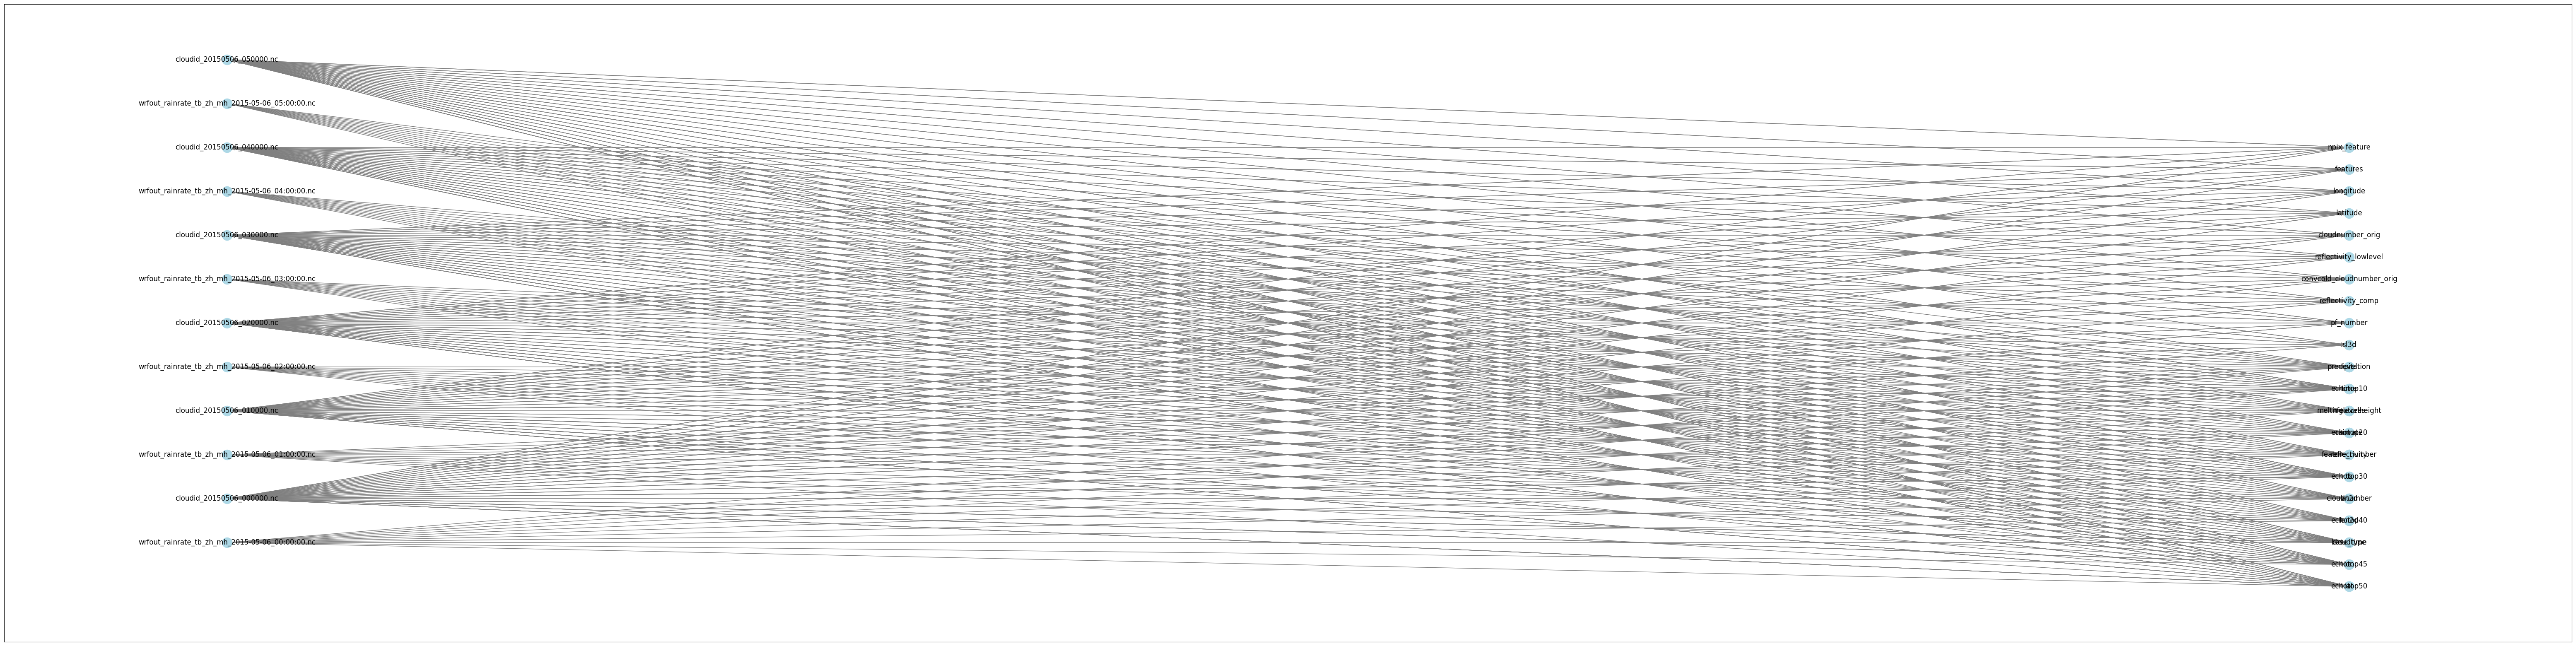

In [33]:


draw_graph(G_VOL, test_name)

In [34]:



add_task_nodes(G_VOL, task_file_map)

G_VOL = add_task_file_dset_edges(G_VOL, task_file_map)

# display_all_nodes_attr(G_VOL)
# print(task_file_map)


    

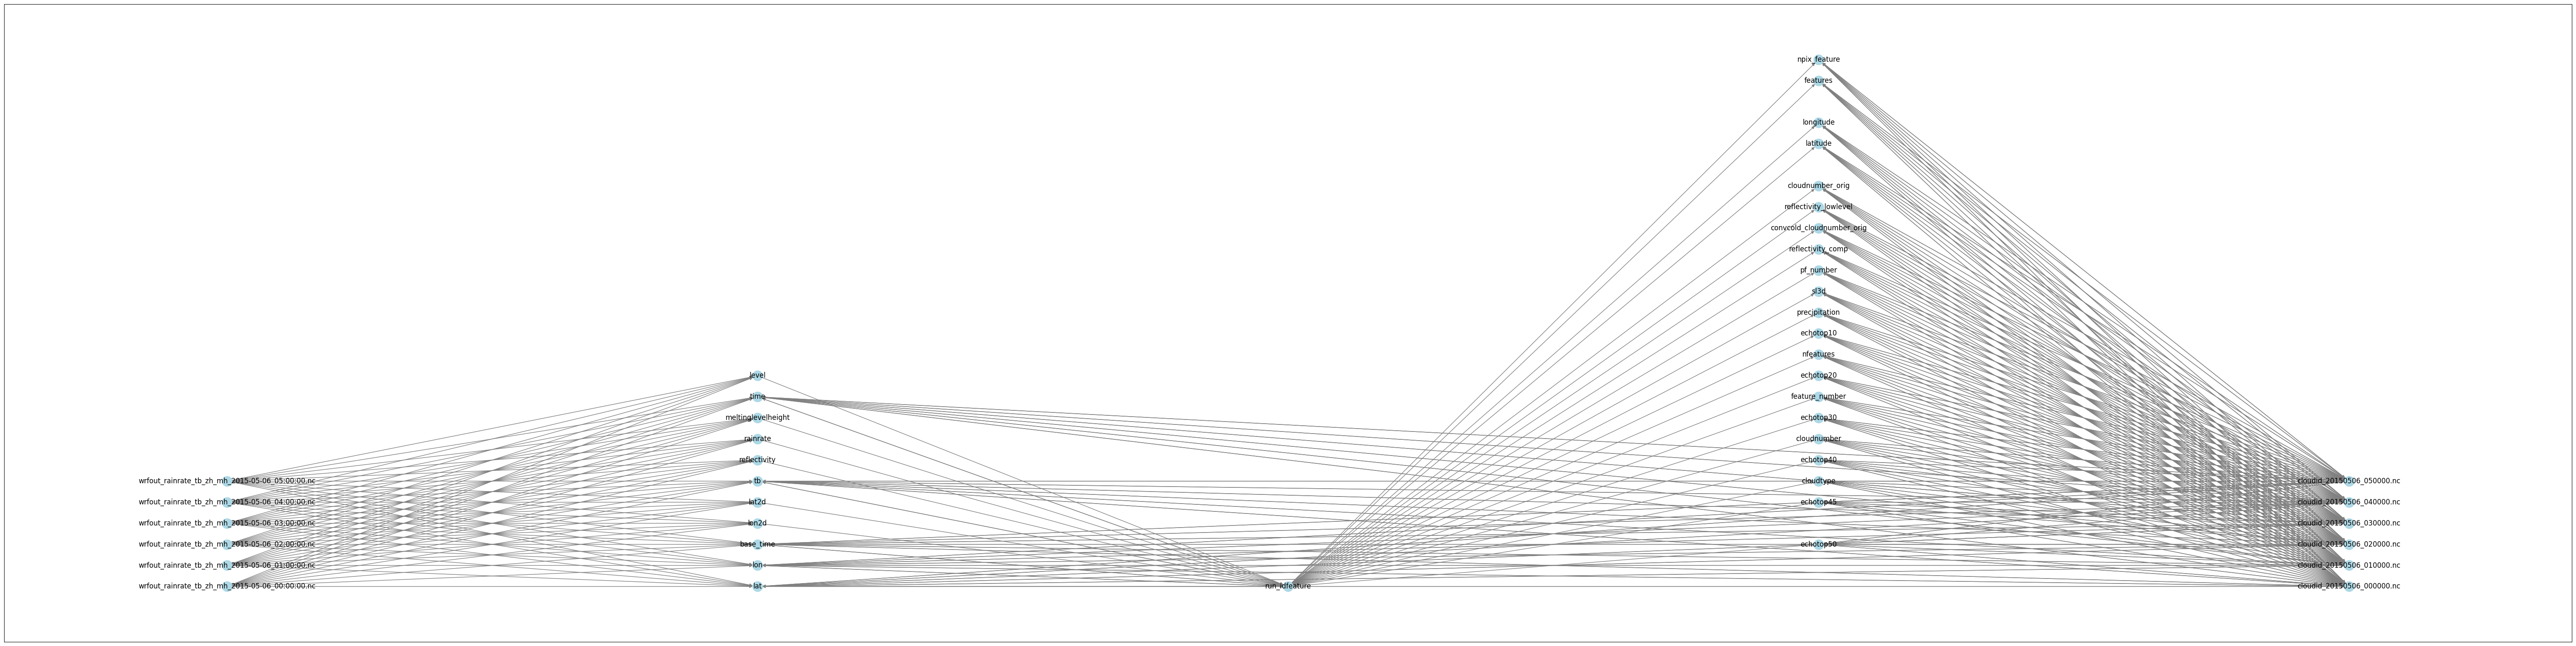

In [35]:
draw_graph(G_VOL, test_name, prefix=f'{(CUT_OFF_STAGE+1)}s', save=True)

# Add networkx to Sankey diagram

## Statistics for Sankey
Below are needed edge attributes before generating the sankey diagram:
- access_cnt : The total file/dataset access count 
- access_size : The total read and write access size
- operation : The operation type : read, write, read_write
- bandwidth : Get the per access size and time, then calculate the bandwidth. Average the bandwidth if multiple accesses. (TODO: currently only recording one access size and time)


In [36]:
def prepare_sankey_stat(G):
    all_edge_attr = {}
    for edge in G.edges():
        u = edge[0]
        v = edge[1]
        has_stat = False
        
        if G.nodes[u]['type'] == 'dataset':
            stats = G.nodes[u]['stat']
            total_access_cnt = G.nodes[u]['access_cnt']
            has_stat = True
        elif G.nodes[v]['type'] == 'dataset':
            stats = G.nodes[v]['stat']
            total_access_cnt = G.nodes[v]['access_cnt']
            has_stat = True
        else:
            print('Error on edge: ', edge)
        
        # print(stats)
        
        if has_stat:
            access_cnt = stats['dataset_read_cnt'] + stats['dataset_write_cnt']
            acesss_size = stats['total_bytes_read'] + stats['total_bytes_written']
            access_time_in_sec = (stats['start_time'] - stats['end_time'])/1000000
            bandwidth = total_access_cnt * (acesss_size / access_time_in_sec)

            edge_attr = {
                    'access_cnt': access_cnt,
                    'access_size': acesss_size,
                    'operation': stats['access_type'],
                    'bandwidth': bandwidth}
            all_edge_attr[edge] = edge_attr
    
    nx.set_edge_attributes(G, all_edge_attr)

prepare_sankey_stat(G_VOL)


In [37]:
# Sankey related codes
EDGE_COLOR_RGBA = {
    'none' : {'r':180, 'g':180, 'b':180}, #grey for open/close/meta
    'read_only' : {'r':150, 'g':190, 'b':220},
    'write_only' : {'r':150, 'g':190, 'b':220},
    'read_write' : {'r':220, 'g':220, 'b':220},
    # 'write' : {'r':140, 'g':210, 'b':220},
}

# color names : https://www.w3schools.com/colors/colors_names.asp
COLOR_MAP = {"task": "Red", # read
            "dataset": "Gold", # yellow
            "file": "MediumBlue", # blue
            "none": "grey",
            }
OPACITY = 0.6

def get_xy_position(G):
    pos_dict = nx.get_node_attributes(G,'pos')

    x_dict = {}
    y_dict = {}
    for n, pos in pos_dict.items():
        x_dict[n] = pos[0]
        y_dict[n] = pos[1]
    
    # shift x position to start from 0
    x_base= min(x_dict.values())
    x_dict = {k: v-x_base for k, v in x_dict.items()}

    # normalize x and y position
    xf=1.0/(max(x_dict.values()))
    x_pos = {k: v*xf for k, v in x_dict.items() }
    
    yf=1.0/max(y_dict.values())
    y_pos = {k: v*yf for k, v in y_dict.items() }
    
    
    return x_pos, y_pos

def get_nodes_for_sankey(G, rm_tags=[],label_on=True):
    node_dict_ref = {}
    node_dict_for_sankey = {'label': [], 'color':[], 'x':[], 'y':[] }
    x_pos, y_pos = get_xy_position(G)
    
    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        # node_type = 'file' if node_name[-4:] == 'residue_100.h5' else 'task'
        # print(f"{idx}, ({node_name}, {attr})")
        
        node_type = attr['type']
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        #sankey
        if label_on :  node_dict_for_sankey['label'].append(node_name)
        node_dict_for_sankey['color'].append(COLOR_MAP[node_type])
        node_dict_for_sankey['x'].append(x_pos[node_name])
        node_dict_for_sankey['y'].append(y_pos[node_name])
    return node_dict_for_sankey, node_dict_ref


def edge_color_scale(attr_bw, attr_op, bw, op):
    range = 100

    base_color_dict = {}
    if op in EDGE_COLOR_RGBA.keys():
        base_color_dict = EDGE_COLOR_RGBA[op]
        r = base_color_dict['r']
        g = base_color_dict['g']
        b = base_color_dict['b']
    else:
        base_color_dict = EDGE_COLOR_RGBA['none']
        r = base_color_dict['r']
        g = base_color_dict['g']
        b = base_color_dict['b']
        color_str = f"rgba({r}, {g}, {b}, {OPACITY})"
        return color_str

    edges = []
    for k,v in attr_op.items():
        if v == op:
            edges.append(k)
    # bw_list = list(set(attr_bw.values()))
    bw_list = [attr_bw[x] for x in edges]
    bw_list.sort()
    # print(bw_list)
        
    color_ranks = stats.rankdata(bw_list,method='dense')
    color_ranks = [float(i)/max(color_ranks) for i in color_ranks] # normalize

    my_rank = color_ranks[bw_list.index(bw)]

    color_change = my_rank *range #(my_rank-1)
    op_change = (my_rank/max(color_ranks)) * 0.5 + 0.4
    color_str = f"rgba({r-color_change/1.5}, {g-color_change/1.5}, {b-color_change/1.5}, {op_change})"

    # print(f"{color_str} rank={my_rank} sqrt={math.sqrt(my_rank)} change={color_change}")
    return color_str

def get_links_for_sankey(G, node_dict_ref,edge_attr=['access_cnt','access_size','operation','bandwidth'],rm_tags=[]):
    link_dict_for_sankey = {'source':[], 'target':[], 'value':[], 'label': [], 'color': []}
    #'hoverinfo': "all"
    #'line_width':[], # shows strokeWidth of the edges
    
    attr_cnt = nx.get_edge_attributes(G,edge_attr[0])
    attr_size = nx.get_edge_attributes(G,edge_attr[1])
    attr_op = nx.get_edge_attributes(G,edge_attr[2])
    attr_bw = nx.get_edge_attributes(G,edge_attr[3])
    
    min_size = min(attr_size.values())
    
    # print(attr_dict)
    for u, v, attr in G.edges(data=True):
        # print(u, v, attr)
        u_idx = node_dict_ref[u]['idx']
        v_idx = node_dict_ref[v]['idx']
        link_dict_for_sankey['source'].append(u_idx)
        link_dict_for_sankey['target'].append(v_idx)

        cnt = attr_cnt[(u,v)]
        size = attr_size[(u,v)]
        graph_size = size
        
        if cnt == 0: cnt = 1
        if size == 0: graph_size = 1
        
        op = attr_op[(u,v)]

        # get edge color based on bandwidth
        link_dict_for_sankey['value'].append(graph_size)
        # _str = f"ave_acc_size: {humansize(size/cnt)} op: {op}"
        bw = attr_bw[(u,v)]
        _str = (f"Access Volume : {humansize(size)} <br />"
            + f"Access Count : {cnt} <br />"
            + f"Average Access Size : {humansize(size/cnt)} <br />"
            + f"Operation : {op}<br />"
            +f"Bandwidth : {humanbw(bw)}")
        
        link_dict_for_sankey['label'].append(_str)

        link_dict_for_sankey['color'].append(edge_color_scale(attr_bw, attr_op, bw, op)) # get the last operation
        # link_dict_for_sankey['acc_cnt'].append(cnt)
        
    return link_dict_for_sankey

def selected_graph(node_name, G):
    # this is not used
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

In [38]:
vol_nodes, vol_nodes_dict = get_nodes_for_sankey(G_VOL, label_on=False)

# print(vol_nodes)

vol_links = get_links_for_sankey(G_VOL, vol_nodes_dict)
fig = go.Figure(go.Sankey(
            node = vol_nodes,
            link = vol_links, orientation='h'))

fig.update_layout(
    autosize=False,
    width=2000,
    height=800,
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=2
    ),
)
# fig.show()

fig.write_html(f"{stat_path}/vol-{(CUT_OFF_STAGE+1)}s-{test_name}-sankey.html")